In [298]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [413]:
# user defined functions

# remove the top and bottom 5% of data
def removeExtreme(df, column):
    max_ = df[column].quantile(0.95)
    min_ = df[column].quantile(0.05)
    return df[(df[column] > min_) & (df[column] < max_)]

# create a distribution of bootstrapped sample means 
def bootstrap(df, column, iterations):
    bootstap_mean = []
    for _ in range(iterations):
        data = np.random.choice(df[column], replace = True, size = iterations)
        bootstap_mean.append(np.mean(data))
    return bootstap_mean 

In [506]:
# define parameters 

ticker = 'WMT'
startDate = '2022-10-01'
endDate = '2022-12-31'
dataInterval = '5m'

fastSMA = 9
normalSMA = 50
slowSMA = 200

# moving average period
rollingPeriod = 21

# entry ratio
entryPercentile = 0.10

# exit ratio
exitPercentile = 0.90

In [507]:
# get data
df = yf.download(ticker, startDate, endDate, interval = dataInterval)
df.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [508]:
# add indicators to dataframe
df['fastSMA'] = df['Close'].rolling(fastSMA).mean()
df['normalSMA'] = df['Close'].rolling(normalSMA).mean()
df['slowSMA'] = df['Close'].rolling(slowSMA).mean()

# drop nulls
df.dropna(inplace=True)
df.reset_index(inplace=True, drop = True)

# If close is higher than slowSMA, then trend in up
df['Trend'] = 'Down'
df.loc[df['Close'] >= df['slowSMA'], 'Trend'] = 'Up'

In [509]:
# calculate the area between slow and fast sma
df['spead_fastSMA_normalSMA'] =  (df['fastSMA'] - df['normalSMA']) / abs(df['Close'] - df['normalSMA'])
df['spead_slowSMA_normalSMA'] =  (df['slowSMA'] - df['normalSMA']) / abs(df['Close'] - df['normalSMA'])

# remove extreme obs
df = removeExtreme(df, 'spead_fastSMA_normalSMA')
df = removeExtreme(df, 'spead_slowSMA_normalSMA')

In [510]:
# define trend 
# slow crossed over fast
df['slowFast_CrossedOver'] = 'Up'
df.loc[df['slowSMA'] >= df['fastSMA'], 'slowFast_CrossedOver'] = 'Down'

# slow crossed over normal
df['slowNormal_CrossedOver'] = 'Up'
df.loc[df['slowSMA'] >= df['normalSMA'], 'slowNormal_CrossedOver'] = 'Down'

# fast crossed over normal
df['fastNormal_CrossedOver'] = 'Up'
df.loc[df['fastSMA'] >= df['normalSMA'], 'fastNormal_CrossedOver'] = 'Down'

# bootstap dataset and calculate sample means
spead_fastSMA_normalSMA_bootstrapped_mean = bootstrap(df, 'spead_fastSMA_normalSMA', 1000)
spead_slowSMA_normalSMA_bootstrapped_mean = bootstrap(df, 'spead_slowSMA_normalSMA', 1000)

# reset index
df.reset_index(inplace=True, drop = True)


In [513]:
# get the date of when the cross over occured
# create empty placeholder initalized with the first period

try:
    period = [df['Date'][0]]
except KeyError:
    period = [df['Datetime'][0]]

keyDate = []
for i in range(len(df) - 1):
    
    # get current and prior status
    currentStatus = df['fastNormal_CrossedOver'][i+1]
    priorStatus = df['fastNormal_CrossedOver'][i]
    
    # if the status has not changed
    if currentStatus == priorStatus:
        # then set the current period equal to the prior one
        period.append(period[-1])
        keyDate.append(0)
    # if there has been a crossover
    else:
        try:
            period.append(df['Date'][i+1])
        except KeyError:
            period.append(df['Datetime'][i+1])
        keyDate.append(1)
keyDate.append(0)
        
# cross over key date?  
df['Date_fastNormal_CrossedOver_key_Date'] = keyDate
# date when cross over occured    
df['Date_fastNormal_CrossedOver'] = period

In [514]:
# merge df to get the Closing price of crossover date
try:
    data = df[['Date','Close']].copy()
except KeyError:
    data = df[['Datetime','Close']].copy()

data.columns = ['Date_fastNormal_CrossedOver','Close_fastNormal_CrossedOver']
df = df.merge(data, how = 'left', left_on = 'Date_fastNormal_CrossedOver', right_on = 'Date_fastNormal_CrossedOver')

# ROI from when the crossover occured
df['ROI_fastNormal_CrossedOver'] = df['Close'] / df['Close_fastNormal_CrossedOver'] - 1

# ROI if strategy was in place
roi = df.loc[df['Date_fastNormal_CrossedOver_key_Date']==1]

In [515]:
try:
    keyColumns = ['Date_fastNormal_CrossedOver','Date','ROI_fastNormal_CrossedOver',
              'slowFast_CrossedOver','fastNormal_CrossedOver','slowNormal_CrossedOver','Trend']
    roi = roi[keyColumns].copy()

    roi['Days_Spread'] = roi['Date'] - roi['Date_fastNormal_CrossedOver']
    roi['Days_Spread'] = [x.days for x in roi['Days_Spread']]
except KeyError:
    keyColumns = ['Date_fastNormal_CrossedOver','Datetime','ROI_fastNormal_CrossedOver',
              'slowFast_CrossedOver','fastNormal_CrossedOver','slowNormal_CrossedOver','Trend']
    roi = roi[keyColumns].copy()
    roi['Days_Spread'] = roi['Datetime'] - roi['Date_fastNormal_CrossedOver']
    roi['Days_Spread'] = [x.days for x in roi['Days_Spread']]
    



In [516]:
roi_bootstrapped_mean = bootstrap(roi, 'ROI_fastNormal_CrossedOver', 1000)
Days_Spread_bootstrapped_mean = bootstrap(roi, 'Days_Spread', 1000)


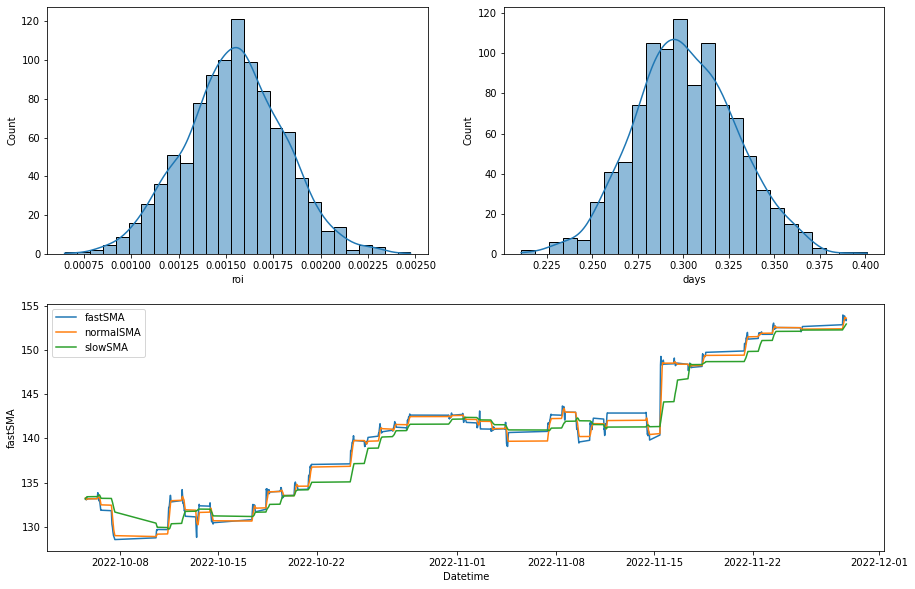

In [519]:
fig = plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.histplot(roi_bootstrapped_mean, kde=True).set(xlabel='roi')

plt.subplot(2,2,2)
sns.histplot(Days_Spread_bootstrapped_mean, kde=True).set(xlabel='days')

plt.subplot(2,1,2)
sns.lineplot(x=df['Datetime'],y=df['fastSMA'], label='fastSMA')
sns.lineplot(x=df['Datetime'],y=df['normalSMA'], label='normalSMA')
sns.lineplot(x=df['Datetime'],y=df['slowSMA'], label='slowSMA')


plt.show()


In [521]:
roi.sort_values('Datetime').tail()

#   Trend Level 1 - Slowest
#         'slowNormal_CrossedOver': 'Slow SMA is ABOVE Normal SMA'
#             -- 'Macro Trend'
#             -- 'Yes': 'Down Trending Long Term Trend'
#             -- 'No': 'Up Trending  Long Term Trend'

#   Trend Level 2 - Normal
#         'Trend': 'Price is ABOVE slow SMA'
#             -- 'Micro Trend'
#             -- 'Up': 'Up Trending Near-Term Trend'
#             -- 'Down': 'Down Trending  Near-Term Trend'

#   Trend Level 3 - Fastest
#         'slowFast_CrossedOver': 'Slow SMA is ABOVE Fast SMA'
#             -- 'Mirco-Mirco Trend'
#             --'Yes': 'Down Trend Micro-Micro Trend'
#             --'No': 'Up Trend Micro-Micro Trend'

#    Entry Signal
#         'fastNormal_CrossedOver': 'Fast SMA is ABOVE Normal SMA'
#             -- 'Entry Signal'
#             -- 'Yes' : 'BUY'
#             -- 'No': 'SELL'

#    Expected ROI
#         'ROI_fastNormal_CrossedOver': 'ROI based on each signal' 
#

roi.rename(columns={'slowNormal_CrossedOver':'Trend-Slow',
                   'Trend':'Trend-Normal',
                   'slowFast_CrossedOver':'Trend-Fast',
                   'fastNormal_CrossedOver':'Signal-Entry-Exit',
                   'ROI_fastNormal_CrossedOver':'Signal-Return',
                   'Days_Spread': 'Signal-Days'}, inplace=True)

In [524]:
roi.groupby(['Trend-Slow','Trend-Normal','Trend-Fast','Signal-Entry-Exit',
             ]).describe()['Signal-Return']

count      mean  \
Trend-Slow Trend-Normal Trend-Fast Signal-Entry-Exit                    
Down       Down         Down       Down                 9.0 -0.004276   
                                   Up                  10.0 -0.004999   
                        Up         Down                 1.0 -0.000071   
           Up           Down       Up                   4.0  0.011786   
Up         Down         Up         Down                 3.0 -0.001059   
           Up           Down       Up                   1.0  0.004322   
                        Up         Down                27.0  0.002951   
                                   Up                  25.0  0.003348   

                                                           std       min  \
Trend-Slow Trend-Normal Trend-Fast Signal-Entry-Exit                       
Down       Down         Down       Down               0.002155 -0.008695   
                                   Up                 0.009395 -0.027050   
                        Up         Down                    NaN -0.000071   
           Up           Down       Up                 0.011158  0.003836   
Up         Down         Up         Down               0.006368 -0.006270   
           Up           Down       Up                      NaN  0.004322   
                        Up         Down               0.009515 -0.013884   
                                   Up                 0.004471 -0.000934   

                                                           25%       50%  \
Trend-Slow Trend-Normal Trend-Fast Signal-Entry-Exit                       
Down       Down         Down       Down              -0.004409 -0.004119   
                                   Up                -0.005506 -0.002940   
                        Up         Down              -0.000071 -0.000071   
           Up           Down       Up                 0.006130  0.007501   
Up         Down         Up         Down              -0.004608 -0.002947   
           Up           Down       Up                 0.004322  0.004322   
                        Up         Down              -0.001542  0.000269   
                                   Up                 0.000425  0.002336   

                                                           75%       max  
Trend-Slow Trend-Normal Trend-Fast Signal-Entry-Exit                      
Down       Down         Down       Down              -0.002901 -0.001791  
                                   Up                -0.000413  0.004759  
                        Up         Down              -0.000071 -0.000071  
           Up           Down       Up                 0.013156  0.028303  
Up         Down         Up         Down               0.001546  0.006039  
           Up           Down       Up                 0.004322  0.004322  
                        Up         Down               0.004968  0.027182  
                                   Up                 0.004191  0.017848

In [538]:
153.33*1.002336

153.68817888

In [525]:
# Best Long Signal
'Trend-Slow' = 'Up',
'Trend-Normal' = 'Up',
'Trend-Fast' = 'Up',
'Signal-Entry-Exit' = 'Down'

# second Best Long Signal
'Trend-Slow' = 'Up',
'Trend-Normal' = 'Up',
'Trend-Fast' = 'Up',
'Signal-Entry-Exit' = 'Up'



# Best Short Signal
'Trend-Slow' = 'Down',
'Trend-Normal' = 'Down',
'Trend-Fast' = 'Down',
'Signal-Entry-Exit' = 'Up'

# second Best Short Signal
'Trend-Slow' = 'Down',
'Trend-Normal' = 'Down',
'Trend-Fast' = 'Down'
'Signal-Entry-Exit' = 'Down'

SyntaxError: cannot assign to literal (<ipython-input-525-ee0574e8a2a0>, line 2)

In [526]:
df.rename(columns={'slowNormal_CrossedOver':'Trend-Slow',
                   'Trend':'Trend-Normal',
                   'slowFast_CrossedOver':'Trend-Fast',
                   'fastNormal_CrossedOver':'Signal-Entry-Exit',
                   'ROI_fastNormal_CrossedOver':'Signal-Return',
                   'Days_Spread': 'Signal-Days',
                  'Date_fastNormal_CrossedOver_key_Date': 'TradeEvent'}, inplace=True)


In [533]:
trade = df[df['TradeEvent']==1]

In [544]:
core_dr = trade[['Date_fastNormal_CrossedOver','Datetime','Close',
              'Trend-Slow','Trend-Normal','Trend-Fast','Signal-Entry-Exit','TradeEvent']]
core_dr.tail()

,Date_fastNormal_CrossedOver,Datetime,Close,Trend-Slow,Trend-Normal,Trend-Fast,Signal-Entry-Exit,TradeEvent
2222,2022-11-23 14:25:00-05:00,2022-11-23 14:40:00-05:00,152.580002,Up,Up,Up,Down,1
2233,2022-11-23 14:50:00-05:00,2022-11-23 15:50:00-05:00,152.649994,Up,Up,Up,Up,1
2234,2022-11-23 15:55:00-05:00,2022-11-23 15:55:00-05:00,152.479996,Up,Up,Up,Down,1
2261,2022-11-25 09:30:00-05:00,2022-11-25 12:05:00-05:00,152.360001,Up,Up,Up,Up,1
2319,2022-11-25 12:10:00-05:00,2022-11-28 13:55:00-05:00,153.330002,Up,Up,Up,Down,1


In [543]:
df[df['Dateime']>=core_dr['']]

,Date_fastNormal_CrossedOver,Datetime,Close,Trend-Slow,Trend-Normal,Trend-Fast,Signal-Entry-Exit,TradeEvent
0,2022-10-05 13:05:00-04:00,2022-10-05 13:05:00-04:00,133.210007,Up,Up,Up,Up,0
1,2022-10-05 13:05:00-04:00,2022-10-05 13:10:00-04:00,133.119995,Up,Down,Up,Up,0
2,2022-10-05 13:05:00-04:00,2022-10-05 13:20:00-04:00,133.434998,Up,Up,Up,Up,1
3,2022-10-05 13:25:00-04:00,2022-10-05 13:25:00-04:00,133.312393,Up,Up,Up,Down,0
4,2022-10-05 13:25:00-04:00,2022-10-05 13:45:00-04:00,133.195007,Down,Down,Down,Down,0
...,...,...,...,...,...,...,...,...
2330,2022-11-28 14:00:00-05:00,2022-11-28 15:20:00-05:00,153.255005,Up,Up,Up,Up,0
2331,2022-11-28 14:00:00-05:00,2022-11-28 15:25:00-05:00,153.089996,Up,Up,Up,Up,0
2332,2022-11-28 14:00:00-05:00,2022-11-28 15:30:00-05:00,153.429993,Up,Up,Up,Up,0
2333,2022-11-28 14:00:00-05:00,2022-11-28 15:45:00-05:00,153.304993,Up,Up,Up,Up,0
